## Problem Definition

* What is an LNA?

    LNA stands for Low-Noise Amplifier. It is an electronic component that amplifies a very weak signal (especially in radio and wireless communication systems) while introducing the minimum possible amount of additional electronic noise. The primary goal of an LNA is to boost the signal's power without significantly degrading its Signal-to-Noise Ratio (SNR).

* What is Noise Figure?

    Noise figure (NF) is a key metric in electronics, especially in radio frequency (RF) and wireless communication systems, that quantifies how much a device degrades the Signal-to-Noise Ratio (SNR) of a signal as it passes through. The noise factor $(F)$ is the linear ratio of the input SNR to the output SNR, $$F = \frac{(S_i / N_i)}{(S_o / N_o)}$$ Where, $S_i / N_i$ is the Signal-to-Noise Ratio at the input and $S_o / N_o$ is the Signal-to-Noise Ratio at the output. The Noise Figure (NF), expressed in decibels (dB), is calculated as:$$NF = 10 \cdot \log_{10}(F)$$

* Why 2.45 GHz?

    The 2.45 GHz frequency is used for Low-Noise Amplifiers (LNAs) because it is the center frequency of the 2.4 GHz Industrial, Scientific, and Medical (ISM) radio band (2.400 to 2.4835 GHz).

In [2]:
# Importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

plt.rcParams['figure.figsize'] = (10, 5)

## Simulation Plan

* Generate a frequency range around 2.45 GHz
* Model a simple LNA gain response
* Model a simple noise figure curve
* Combine them into a basic LNA model
* Automate NF calculations across the band
* Visualize results (gain plot, NF plot)
* Summarize metrics

## Assumptions

* Idealized LNA model for demonstration
* Smooth gain response, not real S-parameters
* Noise figure modeled with simple mathematical functions
* Focus is automation and visualization, not hardware accuracy

## Frequency Axis

We generate a frequency array centered at 2.45 GHz with a 50 MHz span. This will be used for all gain and noise figure calculations.

In [3]:
# Frequency parameters
fc = 2.45e9        # Center frequency 2.45 GHz
span = 50e6        # 50 MHz
num_points = 1001  # high resolution

# Frequency array
freq = np.linspace(fc - span, fc + span, num_points)

freq[:10], freq[-10:] # preview first and last values

(array([2.4000e+09, 2.4001e+09, 2.4002e+09, 2.4003e+09, 2.4004e+09,
        2.4005e+09, 2.4006e+09, 2.4007e+09, 2.4008e+09, 2.4009e+09]),
 array([2.4991e+09, 2.4992e+09, 2.4993e+09, 2.4994e+09, 2.4995e+09,
        2.4996e+09, 2.4997e+09, 2.4998e+09, 2.4999e+09, 2.5000e+09]))

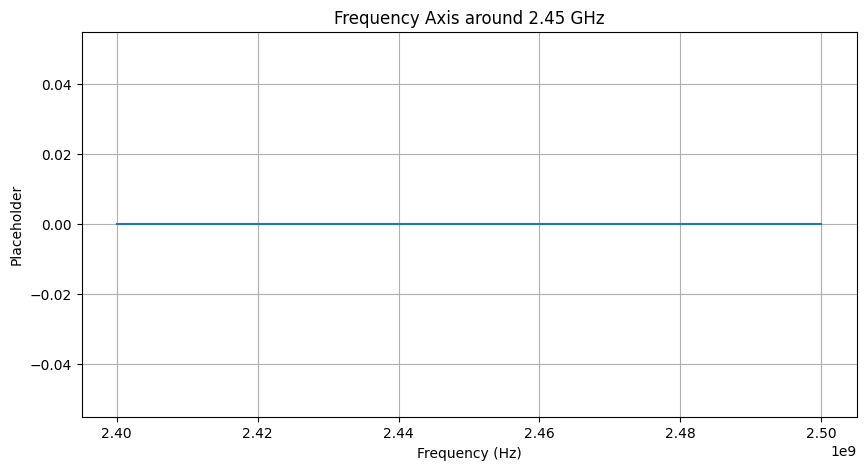

In [4]:
plt.plot(freq, np.zeros_like(freq));
plt.title("Frequency Axis around 2.45 GHz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Placeholder")
plt.grid(True)

### Notes

* Frequency range: 2.40-2.50 GHz
* Resolution: ~100 kHz
* This array will be reused for gain and NF models

### LNA Gain Model

Creating a Gaussian-shaped gain curve peaking near 2.45 GHz (approximately 20 dB peak) and plot it in dB vs frequency in GHz.

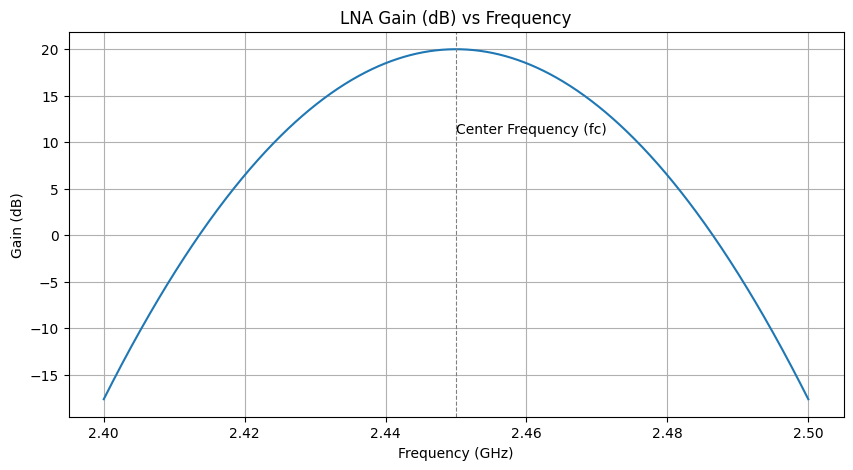

In [26]:
# LNA Gain Model

# Parameters
peak_gain_db = 20
fwhm = 40e6             # Full Width Half Maximum ~ 40 Hz (adjustable)

# converting dB to linear voltage gain (dB referenced to voltage => 20*log10)
peak_gain_lin = 10**(peak_gain_db / 20)

# Gaussian sigma from FWHM: FWHM = 2*sqrt(*ln2)*sigma
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Building a Gaussian-shaped linear gain, then converting to dB
gain_lin = peak_gain_lin * np.exp(-0.5 * ((freq - fc) / sigma)**2)
gain_db = 20 * np.log10(gain_lin)    # converting linear voltage gain to dB

# clamp extremely low values to avoid -inf from log
gain_db = np.clip(gain_db, -60, 100)  # The np.clip function acts as a safety measure. Because the logarithm of a number close to zero 
                                      # can result in negative infinity ($\text{-}\infty$), this line ensures the lowest possible gain is 
                                      # capped at $-60$ dB to prevent plotting errors.

# Plot (frequency in GHz)
plt.plot(freq / 1e9, gain_db)
plt.title("LNA Gain (dB) vs Frequency")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Gain (dB)")
plt.grid(True)

plt.axvline(fc / 1e9, color='gray', linestyle='--', linewidth=0.8) # draws a dashed line at fc and labels it to show where the peak gain occurs.
plt.text(fc / 1e9, peak_gain_db - 9, 'Center Frequency (fc)');

### Noise Figure (NF) Model

We model NF as a small-band variation around a low baseline (e.g., 0.8-2.5 dB). Convert NF (dB) into noise factor and then equivalent noise temperature (Te) using T0 = 290K for later use.

NF at center (2.450 GHz): 1.200 dB
Average NF across band: 1.291 dB
Min NF: 1.200 dB, Max NF: 1.455 dB


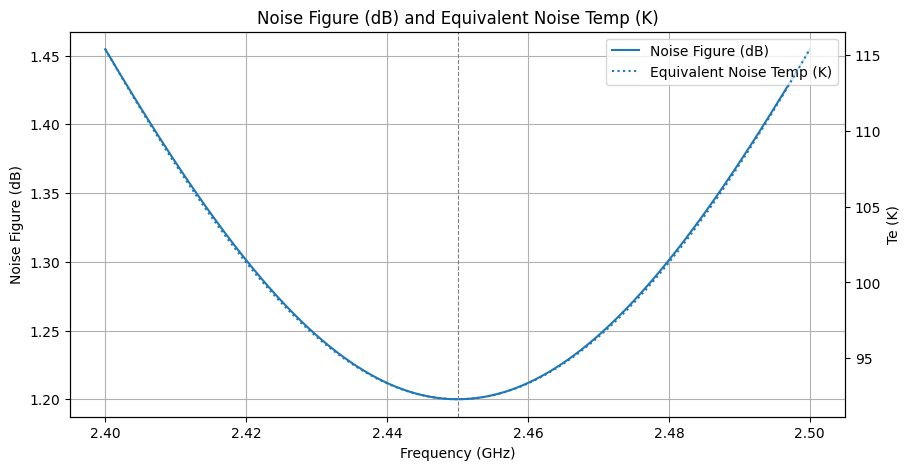

In [41]:
# Noise Figure model

# Noise figure parameters (dB)
nf_center_db = 1.2     # baseline noise figure at center (dB)
nf_ripple_db = 0.8     # peak deviation around center (dB)
nf_rolloff = 60e6      # controls how quickly NF rises off-center

# Building a gentle U-shaped NF curve (combination of Gaussian + quadratic)
nf_db = nf_center_db + nf_ripple_db * (1 - np.exp(-0.5 * ((freq - fc) / nf_rolloff)**2))

# adding a small quadratic trend to make edges slightly worse
nf_db += 0.02 * ((freq - fc) / (span))**2

# Clip to sensible bounds (avoid nonsense)
nf_db = np.clip(nf_db, 0.3, 10)

# converting NF dB into noise factor (linear) and to equivalent noise temperature Te (K)
T0 = 290
nf_lin = 10**(nf_db / 10)
te_k = (nf_lin - 1) * T0

# Plot NF (dB) and Te (K) with twin axis
fig, ax1 =  plt.subplots()
ax1.plot(freq / 1e9, nf_db, label='Noise Figure (dB)')
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('Noise Figure (dB)')
ax1.grid(True)
ax1.axvline(fc / 1e9, color='gray', linestyle='--', linewidth=0.8)

ax2 = ax1.twinx()
ax2.plot(freq / 1e9, te_k, linestyle=':', label='Equivalent Noise Temp (K)')
ax2.set_ylabel('Te (K)')

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('Noise Figure (dB) and Equivalent Noise Temp (K)');

# Quick summary values
print(f"NF at center ({fc / 1e9:.3f} GHz): {np.interp(fc, freq, nf_db):.3f} dB")
print(f"Average NF across band: {np.mean(nf_db):.3f} dB")
print(f"Min NF: {np.min(nf_db):.3f} dB, Max NF: {np.max(nf_db):.3f} dB")